In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import catboost as ctb

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

In [308]:
warnings.filterwarnings('ignore')

In [309]:
sns.set_theme(style="whitegrid", palette="pastel")

In [310]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [311]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [312]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [313]:
print(f"The shape of the training and test datasets are: {train.shape}, {test.shape}")

The shape of the training and test datasets are: (891, 12), (418, 11)


In [314]:
def null_count(x):
    total = x.isnull().sum().sort_values(ascending=False)
    percent = (np.round(x.isnull().sum()/x.isnull().count(), 3)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=["total", "Percent"])
    return missing_data

In [315]:
null_count(train)

,total,Percent
Cabin,687,0.771
Age,177,0.199
Embarked,2,0.002
PassengerId,0,0.000
Survived,0,0.000
Pclass,0,0.000
Name,0,0.000
Sex,0,0.000
SibSp,0,0.000
Parch,0,0.000


In [316]:
null_count(test)

,total,Percent
Cabin,327,0.782
Age,86,0.206
Fare,1,0.002
PassengerId,0,0.000
Pclass,0,0.000
Name,0,0.000
Sex,0,0.000
SibSp,0,0.000
Parch,0,0.000
Ticket,0,0.000


In [317]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [318]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [319]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [320]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


<AxesSubplot:>

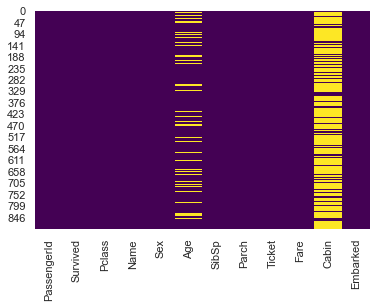

In [321]:
sns.heatmap(train.isnull(),cbar=False,cmap='viridis')

In [322]:
# All the names are diverse
train["Name"].value_counts().sort_values()

Braund, Mr. Owen Harris                         1
Andersson, Mr. Anders Johan                     1
Heikkinen, Miss. Laina                          1
Futrelle, Mrs. Jacques Heath (Lily May Peel)    1
Allen, Mr. William Henry                        1
                                               ..
Montvila, Rev. Juozas                           1
Graham, Miss. Margaret Edith                    1
Johnston, Miss. Catherine Helen "Carrie"        1
Laleff, Mr. Kristo                              1
Dooley, Mr. Patrick                             1
Name: Name, Length: 891, dtype: int64

##### Data imputation

In [323]:
# Age appears to be an important variable so we will fill it with values
train["Age"] = train["Age"].fillna(method='ffill').astype(int)
test["Age"] = test["Age"].fillna(method='ffill').astype(int)

In [324]:
# On the other hand, we can drop the rows of Embarked that are missing and exclude cabin from our analysis since most of its values are missing.
null_count(train)

,total,Percent
Cabin,687,0.771
Embarked,2,0.002
PassengerId,0,0.000
Survived,0,0.000
Pclass,0,0.000
Name,0,0.000
Sex,0,0.000
Age,0,0.000
SibSp,0,0.000
Parch,0,0.000


##### Univariate Analysis

<AxesSubplot:xlabel='Age', ylabel='Density'>

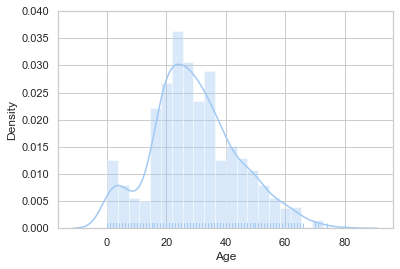

In [325]:
sns.distplot(train["Age"], rug=True)

<AxesSubplot:xlabel='Age', ylabel='Count'>

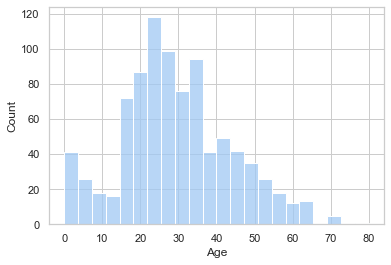

In [326]:
sns.histplot(train["Age"])

In [327]:
train.Age.sort_values()

469     0
644     0
470     0
803     0
305     0
       ..
745    70
96     71
493    71
851    74
630    80
Name: Age, Length: 891, dtype: int32

In [328]:
def bar(x):
    barplot = pd.value_counts(x)
    barplot.plot(kind = "bar", rot=0)
    plt.xticks(range(len(x.unique())))
    plt.show()

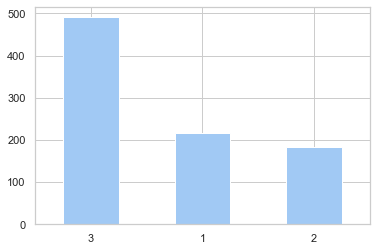

In [329]:
bar(train["Pclass"])

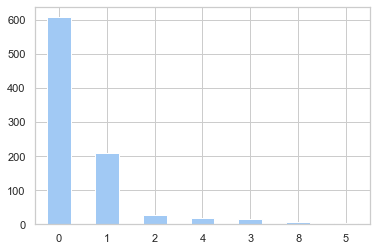

In [330]:
bar(train["SibSp"])

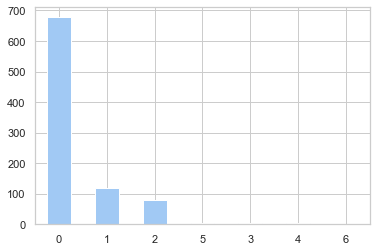

In [331]:
bar(train["Parch"])

In [332]:
train["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [333]:
# Skewness and Kurtosis
def moments(x):
    print("Skewness: %f" % x.skew())
    print("Kurtosis: %f" % x.kurt())

In [334]:
moments(train["Age"])

Skewness: 0.321595
Kurtosis: 0.086058


In [335]:
moments(train["Fare"])

Skewness: 4.787317
Kurtosis: 33.398141


<AxesSubplot:xlabel='Fare', ylabel='Density'>

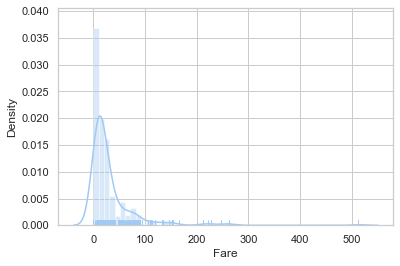

In [336]:
# We can see that both skewness nad Kurtosis are above the value of 1. Therefore, the Variable
# Fare, is unlikely to be normally distributed
sns.distplot(train["Fare"], rug=True)

##### Bivariate Analysis

<AxesSubplot:xlabel='Sex', ylabel='Age'>

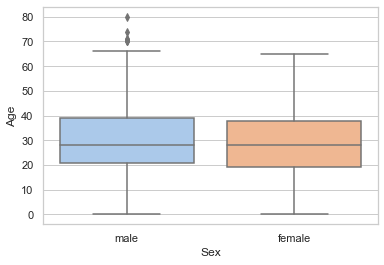

In [337]:
sns.boxplot(x="Sex", y="Age" ,data=train)

In [338]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,19,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32,0,0,370376,7.75,NaN,Q


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Age', ylabel='Fare'>

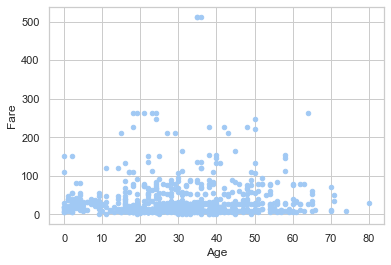

In [339]:
# Crossing Age and Fare once Age has been filled with values
train.plot.scatter(x="Age", y="Fare")

##### Feature Engineering

In [340]:
train["Sex_new"] = np.where(train["Sex"] == "male", 1, 0)
test["Sex_new"] = np.where(test["Sex"] == "male", 1, 0)

In [341]:
train["Embarked_new"] = train["Embarked"].apply(lambda x: 0 if x == "S" else 1 if x == "C" else 2 if "Q" else None)
test["Embarked_new"] = test["Embarked"].apply(lambda x: 0 if x == "S" else 1 if x == "C" else 2 if "Q" else None)

<AxesSubplot:>

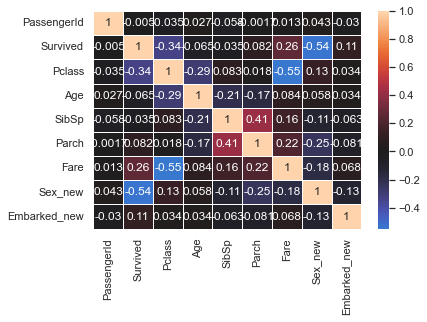

In [342]:
sns.heatmap(train.corr(), annot = True, center=0, linewidths=.5)

In [343]:
train_2 = train.copy()

In [344]:
train_2 = train_2.drop(columns=["Sex", "Embarked", "Name", "PassengerId", "Ticket", "Cabin"],axis=1)
final_results = test[["PassengerId"]]
test = test.drop(columns=["Sex", "Embarked", "Name", "PassengerId", "Ticket", "Cabin"],axis=1)

In [345]:
train_2

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_new,Embarked_new
0,0,3,22,1,0,7.2500,1,0
1,1,1,38,1,0,71.2833,0,1
2,1,3,26,0,0,7.9250,0,0
3,1,1,35,1,0,53.1000,0,0
4,0,3,35,0,0,8.0500,1,0
...,...,...,...,...,...,...,...,...
886,0,2,27,0,0,13.0000,1,0
887,1,1,19,0,0,30.0000,0,0
888,0,3,19,1,2,23.4500,0,0
889,1,1,26,0,0,30.0000,1,1


<AxesSubplot:>

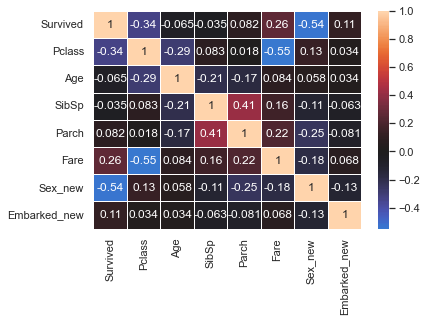

In [346]:
sns.heatmap(train_2.corr(), annot = True, center=0, linewidths=.5)

([<matplotlib.axis.XTick at 0x1e010882910>], [Text(0, 0, '')])

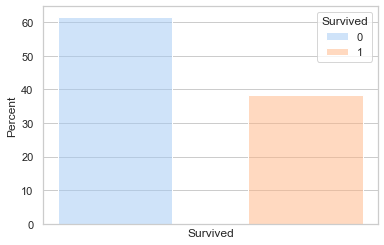

In [347]:
sns.histplot(data=train_2, bins=2, stat="percent", 
             shrink=0.6, x="Survived", hue="Survived")
plt.xticks(np.arange(0, 1))

##### EDA for Survivors and not Survivors

In [348]:
df_surv = train_2.loc[(train_2["Survived"] == 1)] 
df_nsurv = train_2.loc[(train_2["Survived"] == 0)]
print(f"The shape of the survived and not survived datasets are: {df_surv.shape}, {df_nsurv.shape}")

The shape of the survived and not survived datasets are: (342, 8), (549, 8)


In [349]:
# We saw earlier that the 3 variables that seem to have the highest correlation with the variable
# "Survived" are precisely: Sex_new, Fare and Pclass. Also, Embarked_new, but slightly less.
# Now let's explore a little bit more this relationship with only the survived Dataset

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Age', ylabel='Fare'>

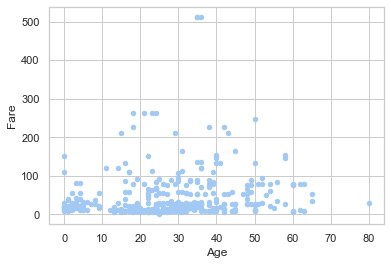

In [350]:
df_surv.plot.scatter(x="Age", y="Fare")

<AxesSubplot:xlabel='Sex_new', ylabel='Age'>

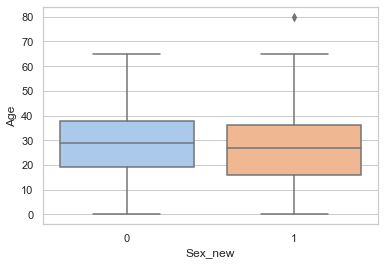

In [351]:
# It appears to be that amongst the survivals the ranges of age are distributed normally
sns.boxplot(x="Sex_new", y="Age" ,data=df_surv)

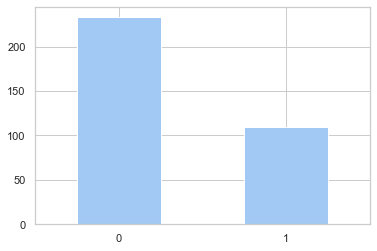

In [352]:
# But in proportion, more women did survive, almost by double
bar(df_surv["Sex_new"])

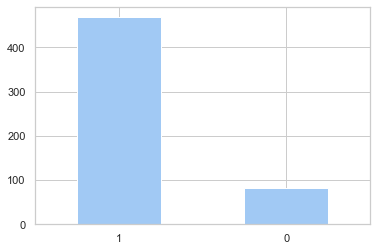

In [353]:
bar(df_nsurv["Sex_new"])

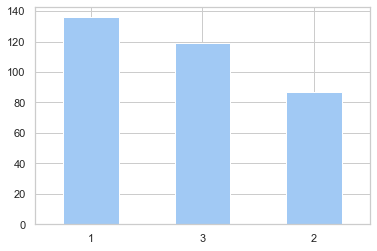

In [354]:
# Now what about Pclass?
bar(df_surv["Pclass"])

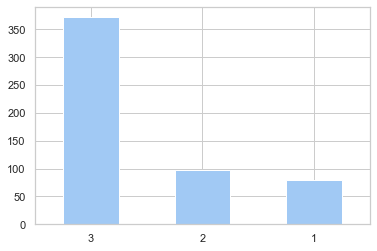

In [355]:
# The disproportion is not so visible, but still those of the lower class have less odds to survive.
bar(df_nsurv["Pclass"])

##### Anomaly detection

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

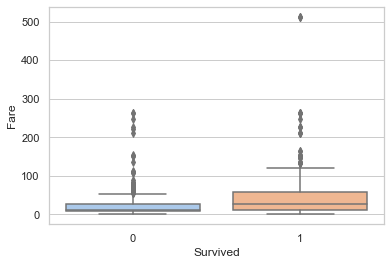

In [356]:
# But the msot important analysis to tackle the hypothesis whether it is possible that higher price
# plays a role in survival is true is to compare Survived with Fare. However, one thing must be noticed,
# We already saw how Fare is correlated to Pclass.
sns.boxplot(x="Survived", y="Fare" ,data=train_2)

In [357]:
# Let's remove the outliers to get a broader insight of what's going on
train_c = train_2[train_2["Fare"] < 120]

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

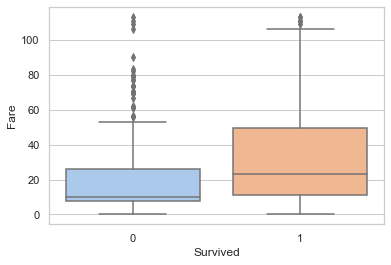

In [358]:
sns.boxplot(x="Survived", y="Fare" ,data=train_c)

In [359]:
# It seems to be that indeed, the higher the fare, the higher the probability of surviving.

##### Model building

In [360]:
y = train_2["Survived"]
x = train_2.drop(["Survived"], axis=1)

In [361]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

In [362]:
model_cbc = ctb.CatBoostClassifier()
model_cbc.fit(X_train, y_train)

Learning rate set to 0.008417
0:	learn: 0.6865817	total: 3.99ms	remaining: 3.99s
1:	learn: 0.6811274	total: 5.13ms	remaining: 2.56s
2:	learn: 0.6776798	total: 5.84ms	remaining: 1.94s
3:	learn: 0.6743957	total: 6.46ms	remaining: 1.61s
4:	learn: 0.6697655	total: 7.14ms	remaining: 1.42s
5:	learn: 0.6638820	total: 8.34ms	remaining: 1.38s
6:	learn: 0.6582899	total: 9.11ms	remaining: 1.29s
7:	learn: 0.6544633	total: 9.87ms	remaining: 1.22s
8:	learn: 0.6496170	total: 11ms	remaining: 1.22s
9:	learn: 0.6442821	total: 12.1ms	remaining: 1.2s
10:	learn: 0.6390147	total: 13.3ms	remaining: 1.2s
11:	learn: 0.6337575	total: 14.5ms	remaining: 1.19s
12:	learn: 0.6286741	total: 15.6ms	remaining: 1.19s
13:	learn: 0.6231638	total: 17.5ms	remaining: 1.23s
14:	learn: 0.6189194	total: 18.4ms	remaining: 1.21s
15:	learn: 0.6143657	total: 19.5ms	remaining: 1.2s
16:	learn: 0.6106820	total: 20.4ms	remaining: 1.18s
17:	learn: 0.6063983	total: 21.5ms	remaining: 1.18s
18:	learn: 0.6021590	total: 22.7ms	remaining: 1.1

303:	learn: 0.3437823	total: 338ms	remaining: 774ms
304:	learn: 0.3435137	total: 340ms	remaining: 775ms
305:	learn: 0.3431582	total: 341ms	remaining: 774ms
306:	learn: 0.3429868	total: 342ms	remaining: 772ms
307:	learn: 0.3426807	total: 343ms	remaining: 771ms
308:	learn: 0.3424466	total: 344ms	remaining: 770ms
309:	learn: 0.3423285	total: 346ms	remaining: 769ms
310:	learn: 0.3422653	total: 346ms	remaining: 767ms
311:	learn: 0.3420173	total: 347ms	remaining: 766ms
312:	learn: 0.3416253	total: 348ms	remaining: 765ms
313:	learn: 0.3416146	total: 349ms	remaining: 762ms
314:	learn: 0.3414713	total: 350ms	remaining: 761ms
315:	learn: 0.3411798	total: 351ms	remaining: 760ms
316:	learn: 0.3409225	total: 352ms	remaining: 759ms
317:	learn: 0.3405929	total: 354ms	remaining: 759ms
318:	learn: 0.3403239	total: 355ms	remaining: 758ms
319:	learn: 0.3400475	total: 356ms	remaining: 757ms
320:	learn: 0.3397676	total: 357ms	remaining: 756ms
321:	learn: 0.3396243	total: 358ms	remaining: 755ms
322:	learn: 

608:	learn: 0.2922591	total: 680ms	remaining: 437ms
609:	learn: 0.2921875	total: 682ms	remaining: 436ms
610:	learn: 0.2918942	total: 683ms	remaining: 435ms
611:	learn: 0.2918103	total: 684ms	remaining: 434ms
612:	learn: 0.2916894	total: 685ms	remaining: 432ms
613:	learn: 0.2916858	total: 686ms	remaining: 431ms
614:	learn: 0.2916230	total: 687ms	remaining: 430ms
615:	learn: 0.2914311	total: 688ms	remaining: 429ms
616:	learn: 0.2912001	total: 689ms	remaining: 428ms
617:	learn: 0.2911569	total: 690ms	remaining: 426ms
618:	learn: 0.2909415	total: 691ms	remaining: 425ms
619:	learn: 0.2909017	total: 692ms	remaining: 424ms
620:	learn: 0.2907037	total: 693ms	remaining: 423ms
621:	learn: 0.2905061	total: 694ms	remaining: 422ms
622:	learn: 0.2903617	total: 695ms	remaining: 421ms
623:	learn: 0.2902550	total: 697ms	remaining: 420ms
624:	learn: 0.2901405	total: 698ms	remaining: 419ms
625:	learn: 0.2898738	total: 699ms	remaining: 418ms
626:	learn: 0.2897904	total: 700ms	remaining: 417ms
627:	learn: 

903:	learn: 0.2550587	total: 1.02s	remaining: 109ms
904:	learn: 0.2549920	total: 1.02s	remaining: 108ms
905:	learn: 0.2548620	total: 1.02s	remaining: 106ms
906:	learn: 0.2546729	total: 1.03s	remaining: 105ms
907:	learn: 0.2545382	total: 1.03s	remaining: 104ms
908:	learn: 0.2544118	total: 1.03s	remaining: 103ms
909:	learn: 0.2542590	total: 1.03s	remaining: 102ms
910:	learn: 0.2541619	total: 1.03s	remaining: 101ms
911:	learn: 0.2540515	total: 1.03s	remaining: 99.6ms
912:	learn: 0.2540053	total: 1.03s	remaining: 98.5ms
913:	learn: 0.2538898	total: 1.03s	remaining: 97.4ms
914:	learn: 0.2537552	total: 1.04s	remaining: 96.3ms
915:	learn: 0.2536585	total: 1.04s	remaining: 95.1ms
916:	learn: 0.2533526	total: 1.04s	remaining: 94ms
917:	learn: 0.2532994	total: 1.04s	remaining: 92.9ms
918:	learn: 0.2531722	total: 1.04s	remaining: 91.8ms
919:	learn: 0.2530968	total: 1.04s	remaining: 90.7ms
920:	learn: 0.2529065	total: 1.04s	remaining: 89.5ms
921:	learn: 0.2528556	total: 1.04s	remaining: 88.4ms
922

In [363]:
expected_y = y_test

In [364]:
predicted_y = model_cbc.predict(X_test)

In [365]:
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       169
           1       0.76      0.67      0.71        99

    accuracy                           0.80       268
   macro avg       0.79      0.77      0.78       268
weighted avg       0.80      0.80      0.80       268

[[148  21]
 [ 33  66]]


In [366]:
results_y = model_cbc.predict(test)

In [367]:
len(results_y)

418

In [368]:
final_results = pd.concat([pd.DataFrame(final_results), pd.DataFrame(results_y)], axis=1)

In [413]:
final_results = final_results.set_axis(["PassengerId", "Survived"], axis=1)

In [415]:
final_results = final_results.reset_index(drop=True)
final_results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


<!-- np.savetxt("prediction.csv", final_results, header="PassengerId, Survived",delimiter=",", fmt="%d", comments="") -->

In [427]:
final_results.to_csv("prediction.csv", index=False)

In [429]:
p = pd.read_csv("prediction.csv")
p.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [ ]:
# Basic EDA and CatBoost Classifier for the Titanic competition.